<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/shape2tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

# Add cell shape features to tracks

### Load required libraries 

In [3]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.measure import  regionprops, regionprops_table
import pandas as pd
import ntpath
import os
import pickle
import copy
import re
import glob
from scipy.stats import skew
from google.cloud import storage


#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries/centers.py /content
from centers import get_centers

###Specify names for bucket and analysis data folder to read data

In [4]:
#@markdown Input required to copy data from bucket to colab (tracks, images and masks)

#@markdown bucketName is the GCP bucket where data is stored
bucketName = 'cellmbucket' #@param {type:"string"}
#@markdown analysis_folder is the name of the base folder in the bucket where the trial folders are found (same name as output_path in segmentationQC_trackingQC notebook excluding '/trial#' part)
analysis_folder='analysis_042221'  #@param {type:"string"}

#bucketName = os.environ.get('cellmbucket')
os.environ['GCLOUD_PROJECT'] = bucketName

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucketName)

###Define functions

In [5]:
#function to read a mask corresponding to a given movie (implicit parameter), and frame (explicit parameter iframe)
get_mask = lambda iframe: imread( masks_folder +'/'+ basename+ '_s' + str(int(movie)) +'_t' + str(int(frame[iframe])) + '.TIF')

#function that returns the mask of a cell centered. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later). 
def get_centered_cell(iframe):
  mask=get_mask(iframe)
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1
  props = measure.regionprops(mask)
  #center image
  centroid=props[0].centroid
  N=mask.shape
  centered=mask[np.ix_((np.arange(N[0]) + int(centroid[0]) - int(N[0]/2)) % N[0] , (np.arange(N[1]) + int(centroid[1]) - int(N[1]/2)) % N[1])]
  return centered

#function that returns the mask of a cell. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later).
def get_cell(iframe):
  mask=get_mask(iframe)  
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1

  return mask

rotation_matrix = lambda angle: np.asarray([[np.cos(angle) , -np.sin(angle)],[np.sin(angle), np.cos(angle)]] )


def skew_from_hist(hist):
  value = np.asarray(range(len(hist)))
  mean = np.sum(hist*value)/np.sum(hist)
  m2 = np.sum(hist*(value-mean)**2)/np.sum(hist)
  m3 = np.sum(hist*(value-mean)**3)/np.sum(hist)
  return  m3/m2**(3/2) 


###Add shape metrics to tracks and save in GCS

In [6]:
for blob in bucket.list_blobs(prefix=analysis_folder):
  if '_tracksqc.pkl' in blob.name:
    output_path = bucketName + '/' + os.path.dirname(blob.name)
    experiment = os.path.basename(blob.name).replace('_tracksqc.pkl', '')

    #Read data 
    #read labeled masks and tracks
    !gsutil cp gs://{output_path}/{experiment}_labeledmasks.zip ./  

    #unzip labeld masks
    !unzip {experiment}_labeledmasks.zip

    masks_folder = experiment+'_labeledmasks'

    #read pickled tracks
    !gsutil cp gs://{output_path}/{experiment}_tracksqc.pkl .
    tracks_filename = experiment+ '_tracksqc.pkl'
    #unpickle tracks  
    with open(tracks_filename, 'rb') as handle:
      tracks_noshape = pickle.load(handle, encoding='latin1') 
    
    #create folder to store masks from tracks
    !mkdir {experiment}_tracks_masks
    
    
    ###Loop to add features to each timepoint of all the tracks
    #Add morphological and morphodynamical features to each timepoint (frame) in the tracks

    tracks = copy.copy(tracks_noshape)

    for itrack in range(len(tracks)):
      tracklength = len(tracks[itrack])
      #store experiment and id_track, to retrieve track_masks from track
      tracks[itrack]["experiment"]=experiment
      tracks[itrack]["track_id"]=str(itrack)
      #read data to retrieve corresponding labeled mask cell
      movie = tracks[itrack]['movie'].iloc[0]
      frame = list(tracks[itrack]['frame'])
      label = list(tracks[itrack]['label'])
      masks=os.listdir(masks_folder)
      #implicit argument to read cells
      basename=re.findall(r"(.+)_s",masks[0])[0] 

      #get polarization angle, skew, protrusion and retraction angle,norm area, radii 
  
      track_masks=[]
      median_centroidy = []
      median_centroidx = []
      protrusion_angles=[]
      mean_protrusion_angles=[]
      protrusion_norm_radii =[]
      protrusion_norm_areas=[]
      retraction_angles=[]
      mean_retraction_angles=[]
      retraction_norm_areas=[]
      retraction_norm_radii=[]
      mean_retraction_norm_radii=[]
      mean_protrusion_norm_radii =[]

      cell_angles = []
      cell_skews = []

      #select scikit-image shape metrics
      shape_metrics = ['area','convex_area','eccentricity','orientation','perimeter','equivalent_diameter','solidity','extent','major_axis_length','minor_axis_length','centroid']

      track_shape_metrics = pd.DataFrame()

      #GET SCIKIT-IMAGE CELL METRICS AND SAVE CELL MASK
      for iframe in range(tracklength):
        cell = get_cell(iframe)    
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        #get median calculated centroid
        celly,cellx = np.where(cell)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )

        #store cell mask
        track_masks.append(cell)

      #SAVE TRACK MASKS AS TIFF STACKS
      track_masks = np.asarray(track_masks)
      imsave(experiment+"_tracks_masks" + '/'+ experiment +"_track"+ str(itrack) + '.TIF' , track_masks)



      for iframe in range(tracklength-1):

        #GET CELL POLARIZATION ANGLE 
        cell_centered = get_centered_cell(iframe)
        props = regionprops(cell_centered)
        #major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
        angle_y = props[0].orientation
        #rotate cell so that major axis is aligned with the y axis
        cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
        #project cell on the x (1) axis
        proj_x = np.sum(cell_y,1)      
        #get cell polarization vector in a regular coordinate system
        #skew sign corresponds to the tail of the distribution, cell polarization is  
        #defined here as -skew. Because image y-axis is inverted, in a regular coordinate
        #system, cell polarization vector is defined as -(-skew) = skew:
        skew_cell = skew_from_hist(proj_x)
        celly_polarization = [0 , skew_cell ]      
        #rotate back
        polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
        cell_angles.append( np.arctan2(polarization[1],polarization[0]) )
        cell_skews.append(abs(skew_cell)) 


        #PROTRUSION AND RETRACTION VECTORS : angle, norm_areas, radii (calculated with medians)
        difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
        #get centroids of cell(iframe), protrusion and retraction
        y,x =np.where(get_centered_cell(iframe))
        centroidy, centroidx = np.median(y), np.median(x)
        yp,xp = np.where(difference==1)
        protrusion_y, protrusion_x  = np.median(yp) , np.median(xp)
        yr,xr = np.where(difference==-1)
        retraction_y, retraction_x  = np.median(yr) , np.median(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        protrusion_angles.append( np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) )
        protrusion_norm_areas.append(len(yp)/ len(y))
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( ((protrusion_x-centroidx)**2+(protrusion_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        retraction_angles.append(np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  )
        retraction_norm_areas.append( len(yr)/len(y) )
        retraction_norm_radii.append( ((retraction_x-centroidx)**2+(retraction_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        #PROTRUSION AND RETRACTION angles, radii, calculated with means
        #get centroids of cell(iframe), protrusion and retraction
        mean_centroidy, mean_centroidx = np.mean(y), np.mean(x)
        mean_protrusion_y, mean_protrusion_x  = np.mean(yp) , np.mean(xp)
        mean_retraction_y, mean_retraction_x  = np.mean(yr) , np.mean(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        mean_protrusion_angles.append(np.arctan2( -(mean_protrusion_y - mean_centroidy), mean_protrusion_x - mean_centroidx) )
        mean_retraction_angles.append(np.arctan2( -(mean_retraction_y - mean_centroidy), mean_retraction_x - mean_centroidx) )
        mean_protrusion_norm_radii.append( ((mean_protrusion_x-mean_centroidx)**2+(mean_protrusion_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        mean_retraction_norm_radii.append( ((mean_retraction_x-mean_centroidx)**2+(mean_retraction_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


      med_centroids = pd.DataFrame({'median_centroidx':median_centroidx, 'median_centroidy':median_centroidy})
  
      shape_features= pd.DataFrame({'polarity_angle':cell_angles, 'abs-skew':cell_skews, 
                                'protr_angle':protrusion_angles, 'mean_protr_angle':mean_protrusion_angles, 'protr_norm_area':protrusion_norm_areas, 
                            'retr_angle': retraction_angles, 'mean_retr_angle': mean_retraction_angles, 'retr_norm_area': retraction_norm_areas,
                            'protr_norm_radii':protrusion_norm_radii, 'mean_protr_norm_radii':mean_protrusion_norm_radii,
                            'retr_norm_radii':retraction_norm_radii, 'mean_retr_norm_radii':mean_retraction_norm_radii, })
  
      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), track_shape_metrics.reset_index(drop=True)], axis = 1 )

      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), med_centroids.reset_index(drop=True)], axis = 1 )

      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), shape_features.reset_index(drop=True)], axis = 1 )

    ###Save updated tracks

    with open(experiment+'_tracks_shape.pkl', 'wb') as handle:
        pickle.dump(tracks, handle, protocol=2)

    #transfer data (tracks_masks and tracks_shape) to GCP bucket
    !zip -r {experiment}_tracks_masks.zip {experiment}_tracks_masks
    !gsutil cp {experiment}_tracks_masks.zip gs://{output_path}

    !gsutil cp {experiment}_tracks_shape.pkl gs://{output_path}

    #remove labeled masks folder and tracks_masks folder from experiment in local folder
    !rm -r {masks_folder}
    !rm -r {experiment}_tracks_masks


Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_labeledmasks.zip...
/ [1 files][  5.8 MiB/  5.8 MiB]                                                
Operation completed over 1 objects/5.8 MiB.                                      
Archive:  06032020-JR20-control_labeledmasks.zip
   creating: 06032020-JR20-control_labeledmasks/
  inflating: 06032020-JR20-control_labeledmasks/sample1_s28_t92.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s19_t99.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s31_t6.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s34_t78.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s11_t91.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s23_t24.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s20_t64.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s34_t15.TIF  
  inflating: 06032020-JR20-control_labeledmasks/sample1_s7_t82.TIF  
  inflating: 06032020-JR20-c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track5.TIF is a

  adding: 06032020-JR20-control_tracks_masks/ (stored 0%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track7.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track21.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track26.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track52.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track1.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track30.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track14.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track17.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track10.TIF (deflated 100%)
  adding: 06032020-JR20-control_tracks_masks/06032020-JR20-control_track3.TIF (deflated 1

# Code to visualize and verify quantificaion of polarization and protrusion/retraction orientation

In [ ]:
# for blob in bucket.list_blobs(prefix=analysis_folder):
#   if '_tracksqc.pkl' in blob.name:
#     output_path = bucketName + '/' + os.path.dirname(blob.name)
#     experiment = os.path.basename(blob.name).replace('_tracksqc.pkl', '')

# #Read data 
# #read labeled masks and tracks
# !gsutil cp gs://{output_path}/{experiment}_labeledmasks.zip ./  

# #unzip labeld masks
# !unzip {experiment}_labeledmasks.zip

# masks_folder = experiment+'_labeledmasks'

# #read pickled tracks
# !gsutil cp gs://{output_path}/{experiment}_tracksqc.pkl .
# tracks_filename = experiment+ '_tracksqc.pkl'
# #unpickle tracks  
# with open(tracks_filename, 'rb') as handle:
#   tracks_noshape = pickle.load(handle, encoding='latin1') 

# #create folder to store masks from tracks
# !mkdir {experiment}_tracks_masks


###Loop to add features to each timepoint of all the tracks
#Add morphological and morphodynamical features to each timepoint (frame) in the tracks

tracks = copy.copy(tracks_noshape)
print(np.shape(tracks))


In [ ]:
!du -sh {masks_folder}

3.9G	060222021_Fascin_KO_sample4_labeledmasks


In [ ]:
tracks[1]

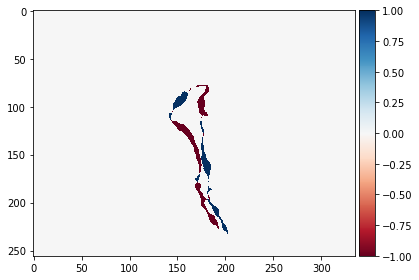

In [ ]:
itrack=6
iframe=5
movie = tracks[itrack]['movie'][0]
frame = list(tracks[itrack]['frame'])
label = list(tracks[itrack]['label'])
masks=os.listdir(masks_folder)
basename=re.findall(r"(.+)_s",masks[0])[0] 
#imshow(get_centered_cell(iframe))
difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
imshow(difference)
#print(basename,movie)

In [ ]:
# cell = get_cell(iframe)

# shape_metrics = ['area','convex_area','eccentricity','orientation','perimeter','equivalent_diameter','solidity','extent','major_axis_length','minor_axis_length','centroid']
# props = measure.regionprops_table(cell, properties=shape_metrics)
# props

#import inspect
#props = measure.regionprops(cell)
#inspect.getmembers(props[0])


In [ ]:
cell_centered = get_centered_cell(iframe)
props = regionprops(cell_centered)
#major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
angle_y = props[0].orientation
#rotate cell so that major axis is aligned with the y axis
cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
#project cell on the x (1) axis
proj_x = np.sum(cell_y,1)      
#get cell polarization vector in a regular coordinate system
#skew sign corresponds to the tail of the distribution, cell polarization is  
#defined here as -skew. Because image y-axis is inverted, in a regular coordinate
#system, cell polarization vector is defined as -(-skew) = skew:
skew_cell = skew_from_hist(proj_x)
celly_polarization = [0 , skew_cell ]      
#rotate back
polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
cell_angle =  np.arctan2(polarization[1],polarization[0]) 


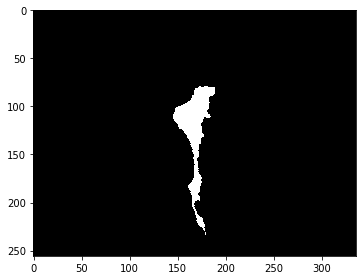

In [ ]:
imshow(cell_y)

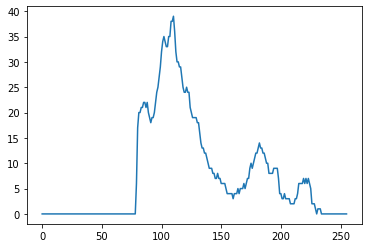

In [ ]:
plt.plot(proj_x)

In [ ]:
print(angle_y*180/np.pi, skew_cell, cell_angle*180/np.pi )

7.951570537678358 0.9244759077157724 97.95157053767836


In [ ]:
polarization

array([-0.12788832,  0.9155874 ])

In [ ]:
#PROTRUSION AND RETRACTION VECTORS : angle, norm_areas
difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
#get centroids of cell(iframe), protrusion and retraction
y,x =np.where(get_centered_cell(iframe))
centroidy, centroidx = np.mean(y), np.mean(x)
yp,xp = np.where(difference==1)
protrusion_y, protrusion_x  = np.mean(yp) , np.mean(xp)
yr,xr = np.where(difference==-1)
retraction_y, retraction_x  = np.mean(yr) , np.mean(xr) 
#get protr and retr angle in a regular coordinate system: [ximage , - yimage]
#and norm_areas
protrusion_angle=np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) 
protrusion_norm_area=len(yp)/ len(y)
retraction_angle=np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  
retraction_norm_area= len(yr)/len(y) 


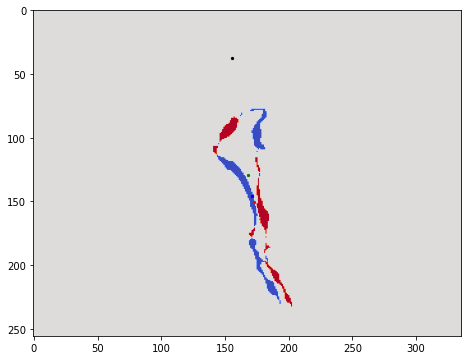

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax_image = fig.add_subplot(111) 
retraction =copy.copy(difference)
retraction[retraction!=-1] = 0
protrution = copy.copy(difference)
protrution[protrution != 1] = 0
ax_image.imshow(difference, cmap='coolwarm')
#ax_image.imshow(protrution,cmap='coolwarm')
ax_image.scatter(centroidx,centroidy,color='green',s=5)
ax_image.scatter(protrusion_x,protrusion_y,color='red',s=5)
ax_image.scatter(retraction_x,retraction_y,color='blue',s=5)
ax_image.scatter(centroidx + 100*polarization[0], centroidy - 100*polarization[1],color='black',s=5)

In [ ]:
print( cell_angle*180/np.pi, protrusion_angle*180/np.pi, retraction_angle*180/np.pi   )

97.95157053767836 -77.37085019733725 -78.90613483319466
